# 3.3 Clustering and Pattern Recognition (External Event)


Recognizing the “external events” can be approached in two directions: one is to treat every time series separately and monitor any unexpected changes happened to the sensor signals, and the other one is to assume the events affect multiple features at the same time so that we hope to distinguish the events by looking at the unique characteristics shown in different features. In this case, if we have labeled data, it would be a common classification problem, but even without labels, we are still able to approach by clustering.


Clustering is an unsupervised machine learning technique that finds similarities between data according to the characteristics and groups similar data objects into clusters. It can be used as a stand-alone tool to get insights into data distribution and can also be used as a preprocessing step for other algorithms. There are many distinct methods of clustering, and here I am using two of the most commonly used ones: K-Means and DBSCAN.


K-means is one of the partitioning methods used for clustering. It randomly partitions objects into nonempty subsets and constantly adding new objects and adjust the centroids until a local minimum is met when optimizing the sum of squared distance between each object and centroid. On the other hand, Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a density-based method where a cluster is defined as the maximal set of density-connected points.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

## Data Preparation

In [2]:
# Load dataframes from pickle file
with open('data/data_full.pkl', 'rb') as f:
    data, data_norm = pickle.load(f)

In [3]:
def is_outlier(data, rolling_median, thresh):
    if not pd.isna(rolling_median):
        return abs(data - rolling_median) >= thresh

In [4]:
# Remove outliers/point anomalies
data_nrm5 = data_norm.rolling(5, center=True).median()
data_nc = data_norm.copy()
s = data_nc.shape
for j in range(s[1]):
    for i in range(s[0]):
        if is_outlier(data_nc.iloc[i, j], data_nrm5.iloc[i, j], 0.2):
            data_nc.iloc[i, j] = data_nrm5.iloc[i, j]

In [6]:
# Calculate the first 3 principal components of data_norm
pca = PCA(n_components=3)
data_pca3 = pca.fit_transform(data_nc)
data_pca3 = pd.DataFrame(data_pca3, columns=['PC1', 'PC2', 'PC3'])

## KMeans

In [7]:
# Run k-means algorithm using cluster centers from 1 to 20 
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_nc)
    sse.append(kmeans.inertia_)

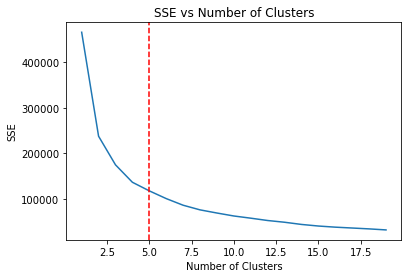

In [8]:
# Use the elbow method to determine the good number of clusters. In this case, it's 5
plt.plot(range(1, 20), sse)
plt.axvline(5, linestyle='--', c='red')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('SSE vs Number of Clusters')
plt.show()

In [9]:
# Rerun the K-means using 5 cluster centers
kmeans = KMeans(n_clusters=5, random_state=30)
labels = kmeans.fit_predict(data_nc)
data_pca3['label_kmean'] = labels

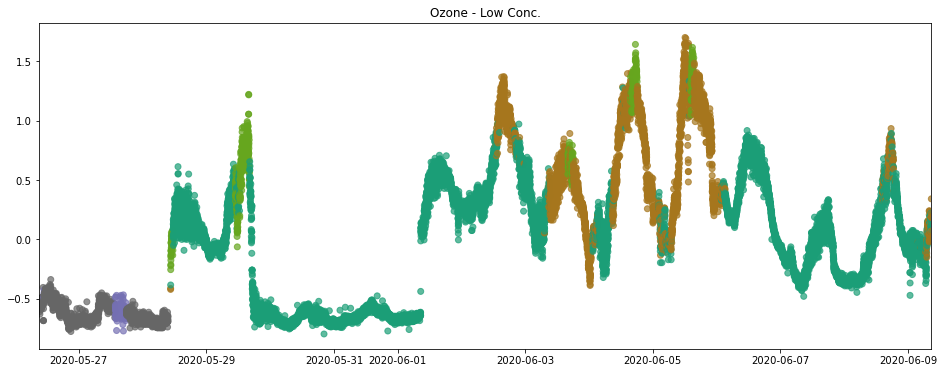

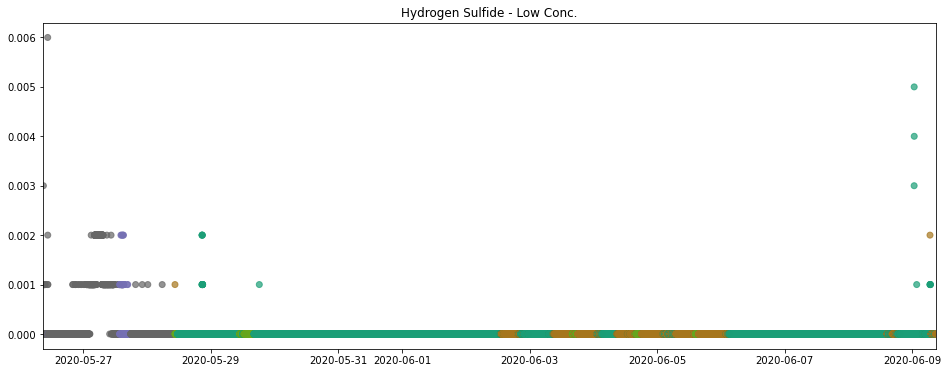

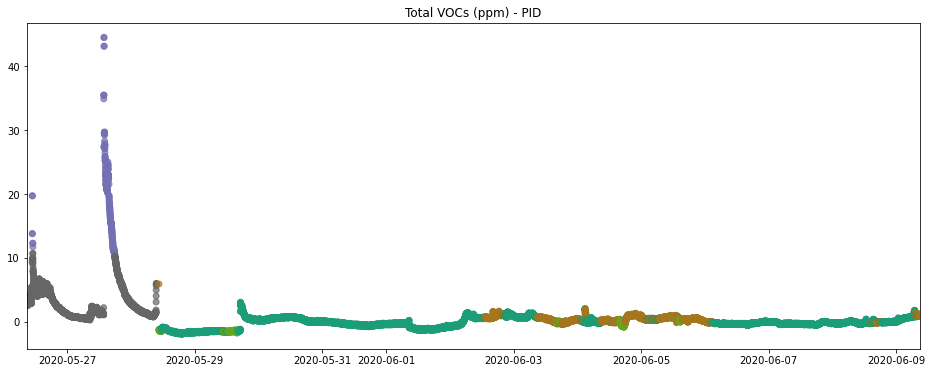

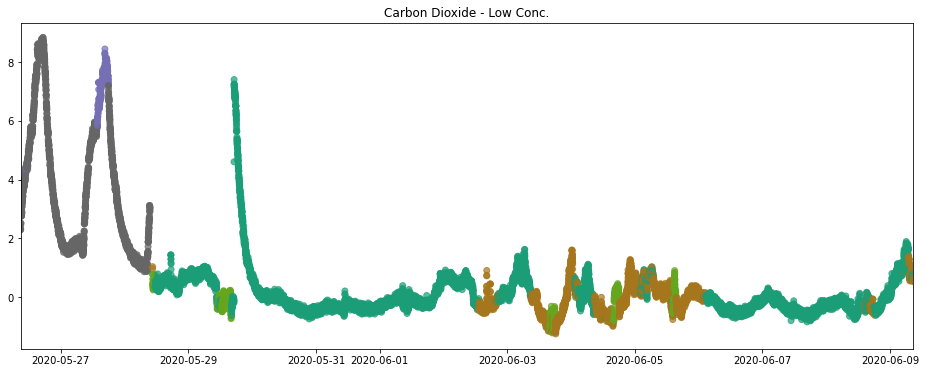

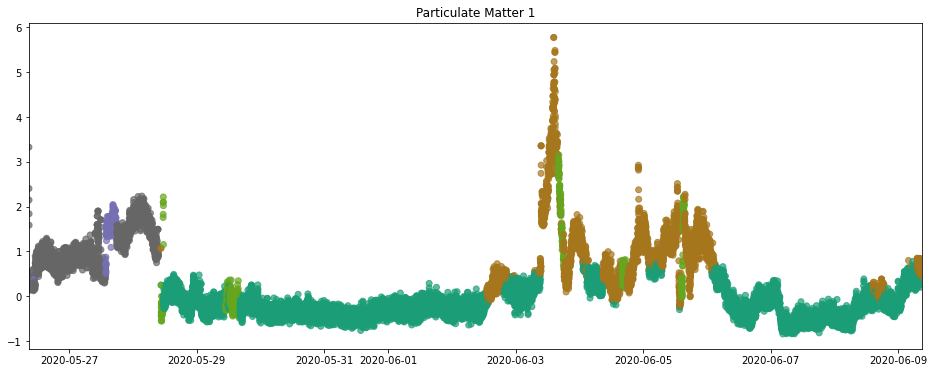

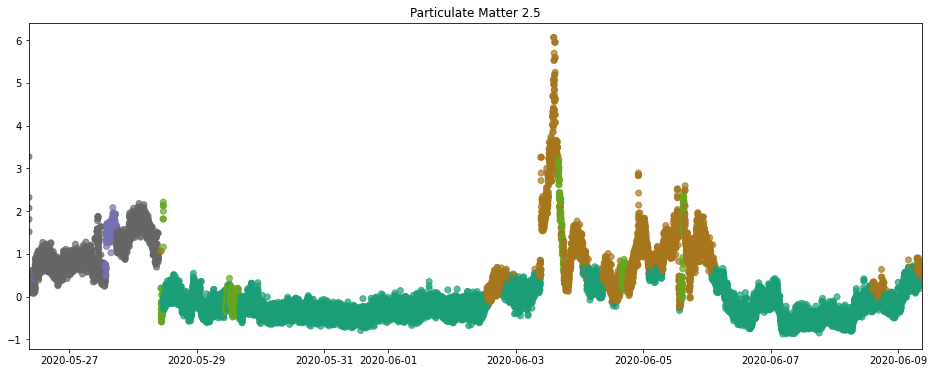

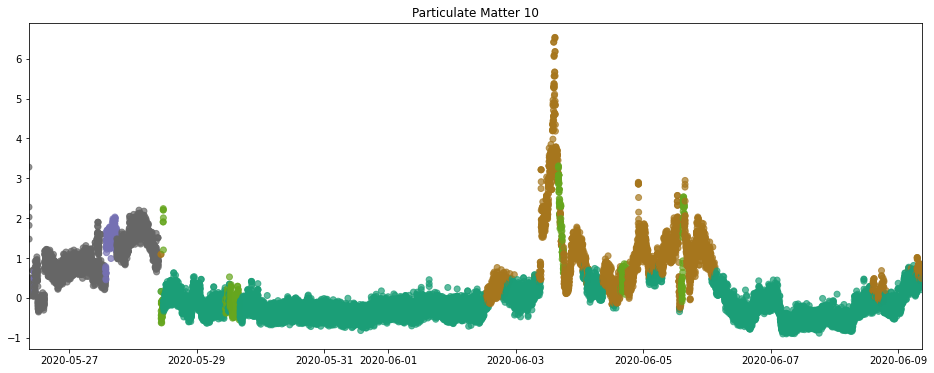

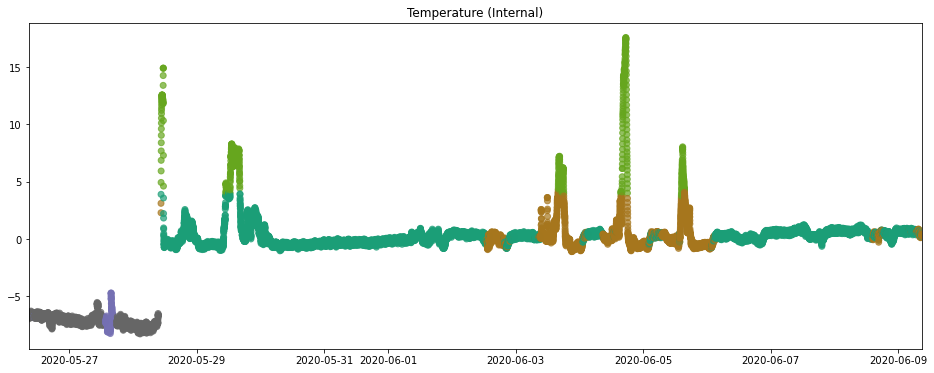

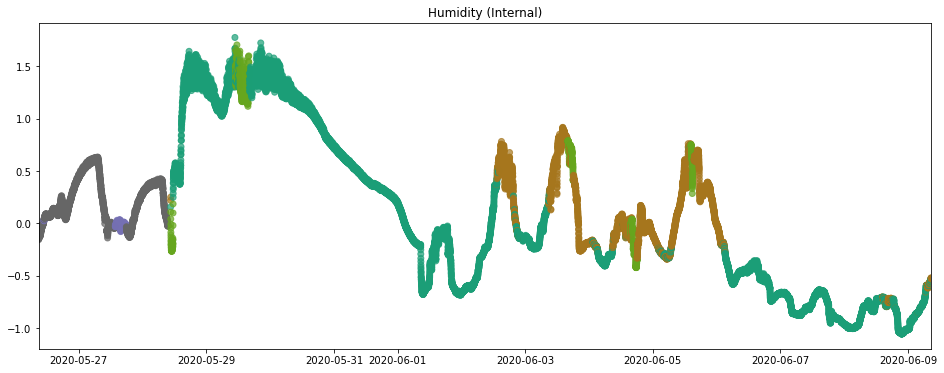

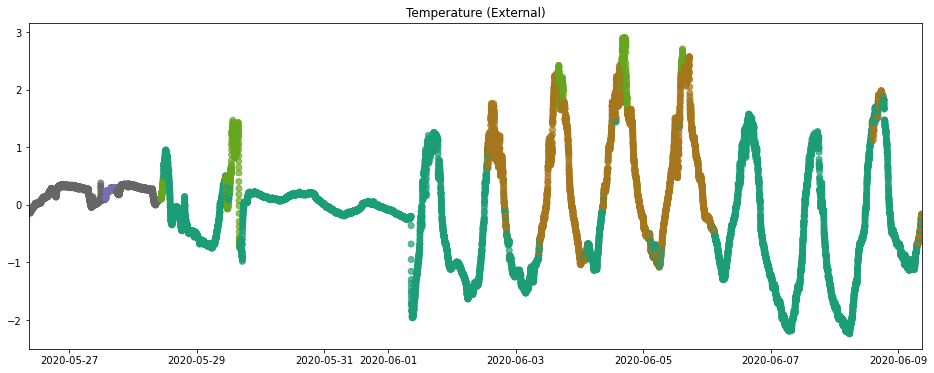

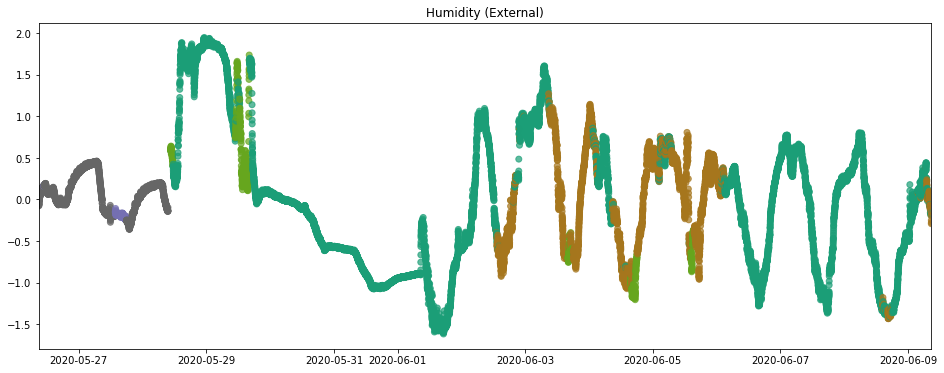

In [10]:
# Plot each of the time series with labeled clusters
for col in data.columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    scatter = plt.scatter(data_nc.index, data_nc[col], c=labels, cmap=plt.get_cmap('Dark2'), alpha=0.7)
    plt.xlim([data.index[0], data.index[-1]])
    plt.title(col)
    plt.show()

## DBSCAN

In [11]:
# Run the DBSCAN algorithm
dbscan = DBSCAN(eps=0.14, min_samples=5)
labels = dbscan.fit_predict(data_norm)
data_pca3['label_DBSCAN'] = labels

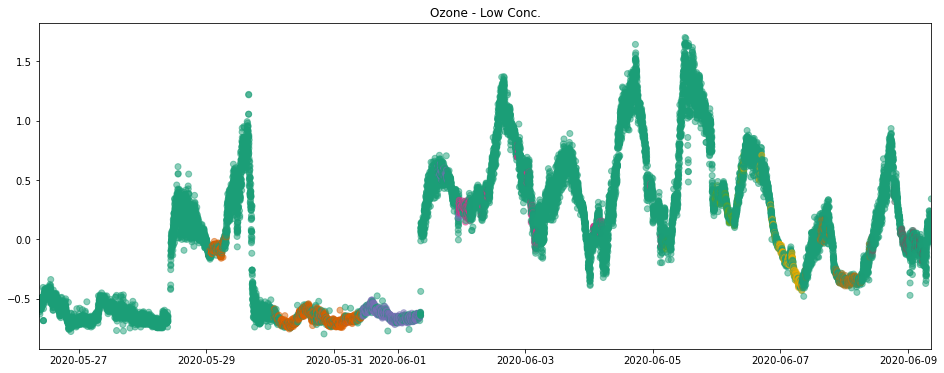

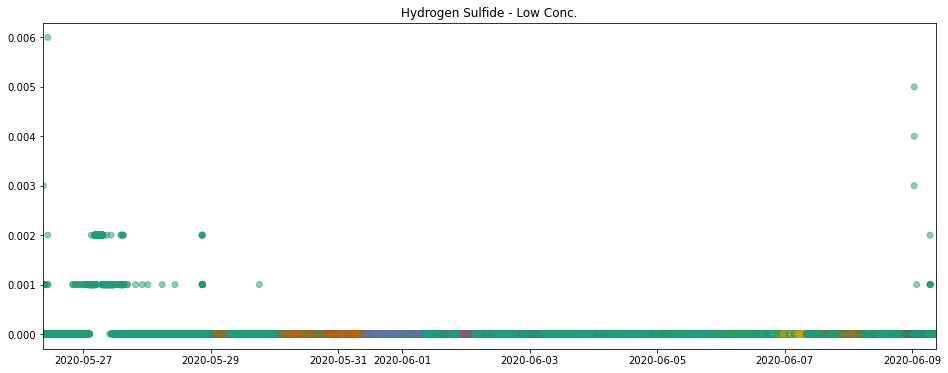

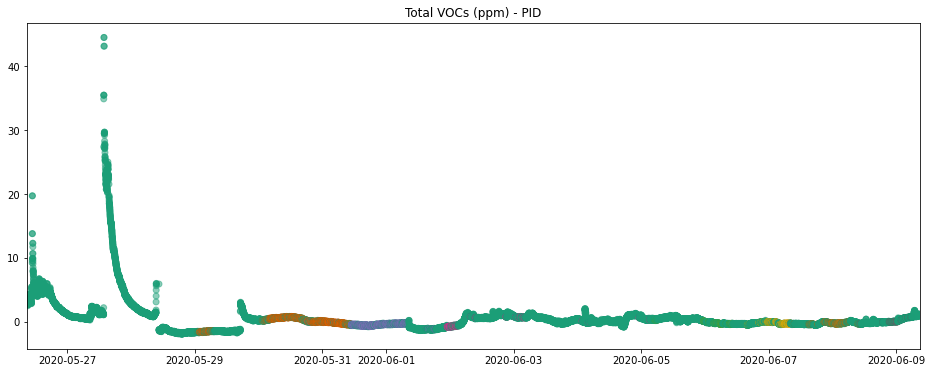

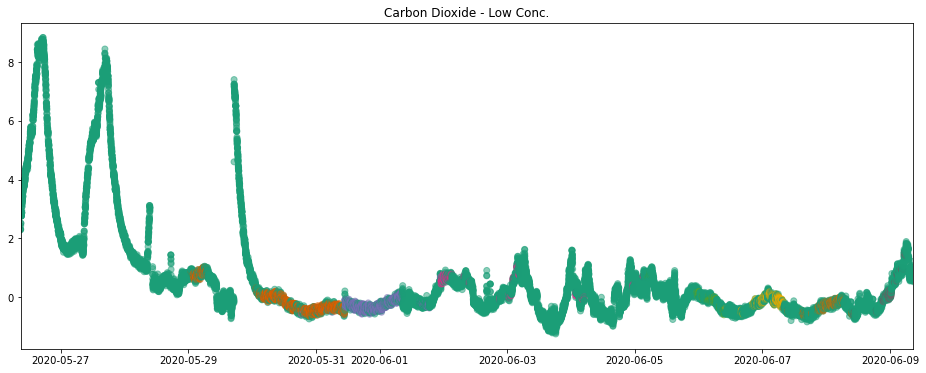

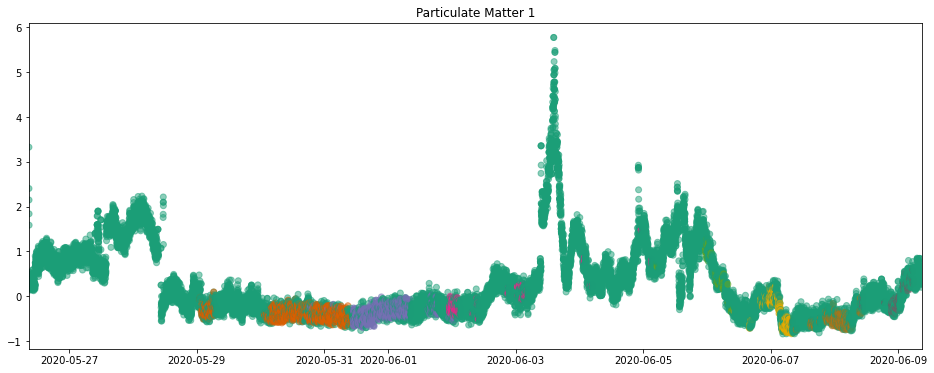

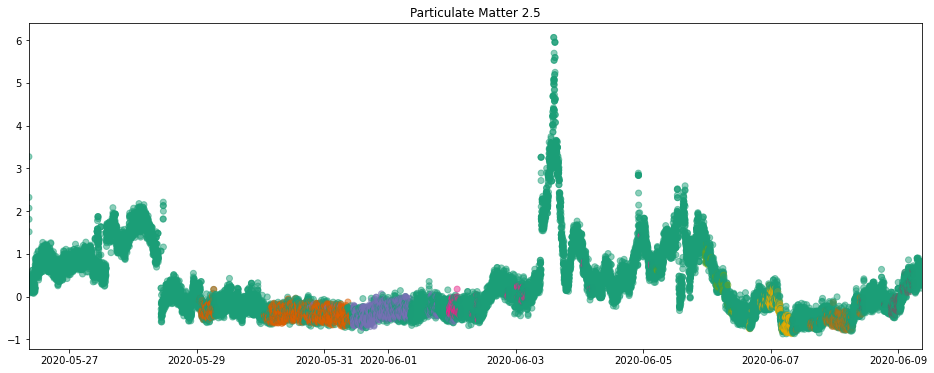

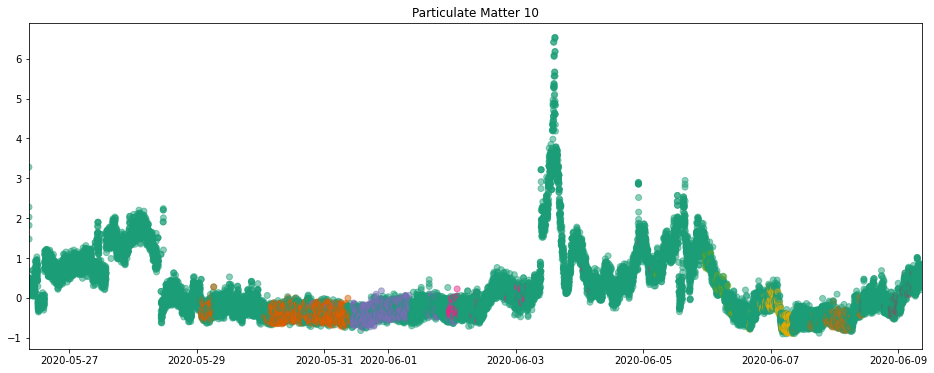

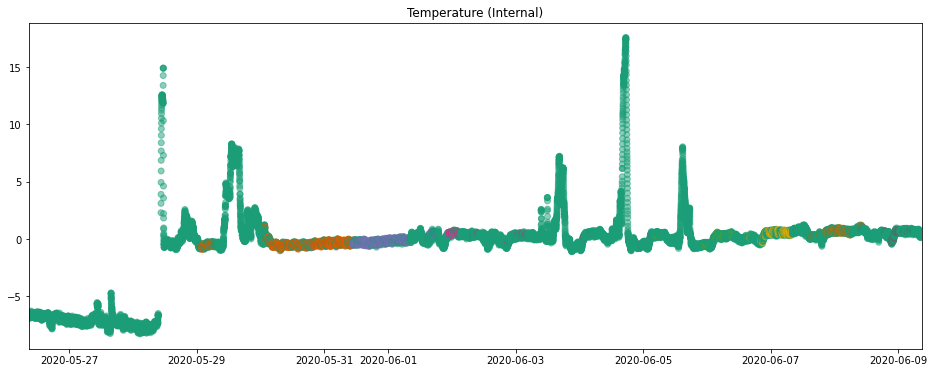

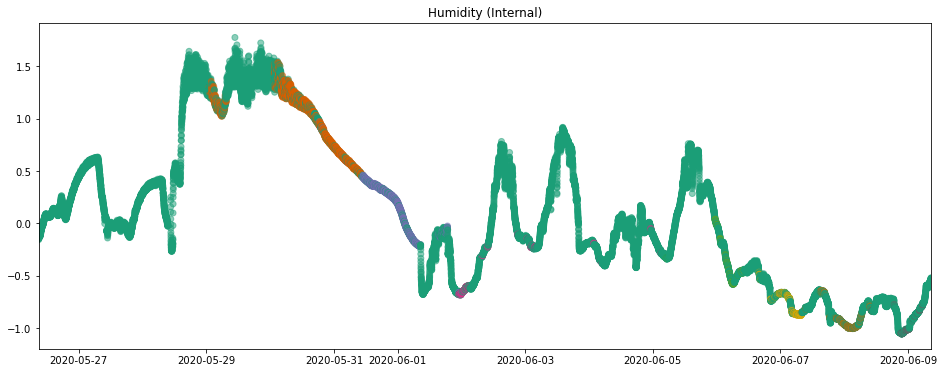

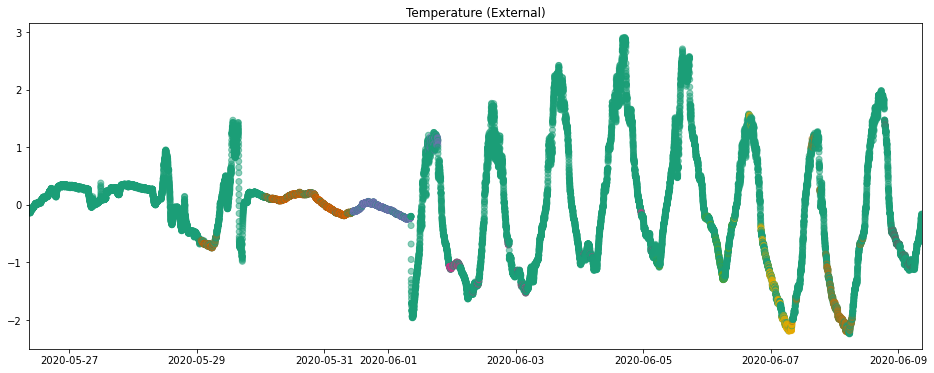

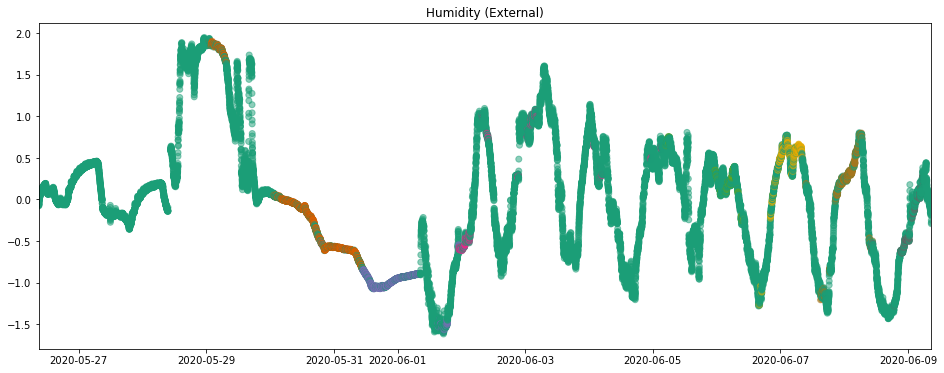

In [12]:
# Plot each of the time series with labeled clusters
for col in data_nc.columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    plt.scatter(data_nc.index, data_nc[col], c=labels, alpha=0.5, cmap=plt.get_cmap('Dark2'))
    plt.xlim([data_nc.index[0], data_nc.index[-1]])
    plt.title(col)
    plt.show()

## Visualize and Compare

C:\Users\DATASC~1\AppData\Local\Temp/ipykernel_32220/1380669773.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tick, rotation=30)
C:\Users\DATASC~1\AppData\Local\Temp/ipykernel_32220/1380669773.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tick, rotation=30)


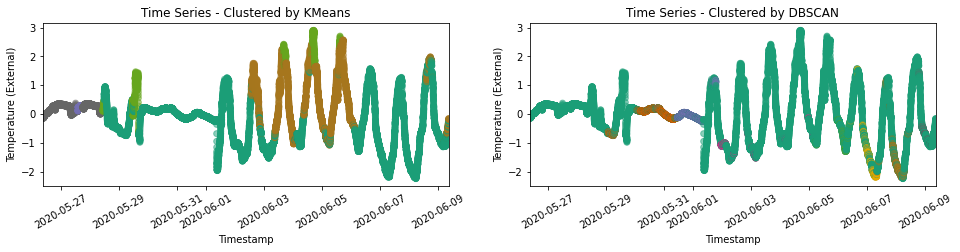

In [13]:
# Plot the Temperature (External) time series side by side
tick = ax.get_xticklabels()
fig, axs = plt.subplots(1, 2, figsize=(16, 3))
labels = [data_pca3['label_kmean'], data_pca3['label_DBSCAN']]
titles = ['Time Series - Clustered by KMeans', 'Time Series - Clustered by DBSCAN']
for i in range(2):
    scatter = axs[i].scatter(data_nc.index, data_nc['Temperature (External)'], c=labels[i], 
                      alpha=0.5, cmap=plt.get_cmap('Dark2'))
    axs[i].set_xlim([data_nc.index[0], data_nc.index[-1]])
    axs[i].set_xticklabels(tick, rotation=30)
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('Temperature (External)')
    axs[i].set_title(titles[i])
plt.show()

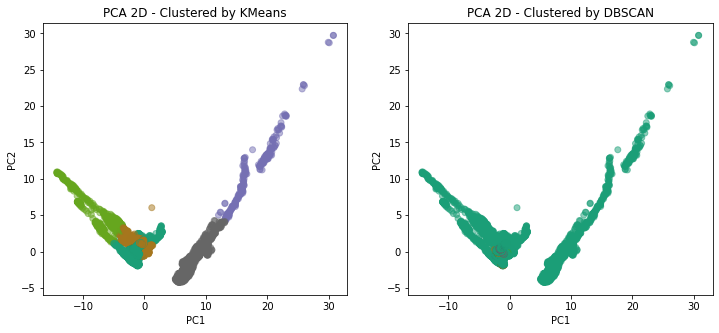

In [14]:
# Scatter plot of first 2 PCs
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
labels = [data_pca3['label_kmean'], data_pca3['label_DBSCAN']]
titles = ['PCA 2D - Clustered by KMeans', 'PCA 2D - Clustered by DBSCAN']
for i in range(2):
    axs[i].scatter(data_pca3['PC1'], data_pca3['PC2'], c=labels[i], 
                      alpha=0.5, cmap=plt.get_cmap('Dark2'))
    axs[i].set_xlabel('PC1')
    axs[i].set_ylabel('PC2')
    axs[i].set_title(titles[i])
plt.show()

Principal Components Analysis (PCA) is a dimension reduction technique that creates new uncorrelated variables in order to increase interpretability and minimize information loss. In this project, after applying K-means and DBSCAN algorithms on the normalized data, PCA is performed and the clustering results are plotted in both 2D (Figure 7) and 3D (Figure 8) using the first 2 and 3 principal components. In addition, to view the clustering results from another perspective, the labeled time series plots are made, and the Temperature (External) plot is shown in Figure 9 as an example.

From the plots, it can be clearly seen that both methods are able to distinguish between the indoor/outdoor pattern changes that I mentioned in section 2.1. The main difference is that the partition-based K-means method is more sensitive to the magnitude changes caused by day/night alternation. Many variables in the dataset are subject to such obvious sinusoidal changes that happen at the same time, including Temperature (External and Internal), Humidity (External and internal) and Ozone. K-means tend to treat peaks and valleys differently. On the other hand, density-based DBSCAN cares less about the magnitude difference but pays more attention to the density distributions. Therefore, it clusters the whole sinusoidal part as one mass cloud as seen in Figure 7 and Figure 8.

It is not possible to comment on which clustering method is better than the other at this stage because they are distinctive enough to function for different interests. If we are more interested in treating the high-low portions of the sinusoidal signals differently, we are going to use K-means; if we only want to distinguish between indoor/outdoor mode, then DBSCAN is better. In addition, since it is an unsupervised learning task, there is no way of quantifying the performance between models except for visualizing and judging by experience. In the future, if some labeled data is provided, the results can be turned into a semi-supervised learning task, and more intuitions can be gained toward model selection.

In [15]:
# Scatter plot of first 3 PCs
fig = plt.figure(figsize=(16, 6))
labels = [data_pca3['label_kmean'], data_pca3['label_DBSCAN']]
titles = ['PCA 3D - Clustered by KMeans', 'PCA 3D - Clustered by DBSCAN']

for i in range(2):
    ax = fig.add_subplot(1, 2, i+1, projection="3d")
    ax.scatter3D(data_pca3['PC1'], data_pca3['PC2'], data_pca3['PC3'], c=labels[i], 
                      alpha=0.5, cmap=plt.get_cmap('Dark2'))
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(titles[i])
    ax.view_init(30, 30)
plt.show()

AttributeError: 'Axes3DSubplot' object has no attribute '_shared_x_axes'

<Figure size 1152x432 with 0 Axes>

In this post, I briefly walk through the approaches and findings of exploratory data analysis and correlation analysis, as well as the constructions of three distinct modeling pipelines that used for point anomaly detection, collective anomaly detection, and clustering.

In the exploratory data analysis section, the sensor reading time intervals are found to vary severely. Even if most of them are contained around a minute, the inconsistency problem is still worth looking into due to the fact that it might lower the efficiency and performance of analytical tasks. The measuring environment is found subject to changes from the time series plots and later reassured by aligning with the actual Toronto weather data as well as the clustering results. In addition, the correlation between features is studied and exemplified. A few confusions are raised such as the strange relationship between Temperature (Internal) and Temperature (External), which needs to be studied through experiments or the device itself.
In the anomaly detection section, since “system fault” and “external event” are not clearly defined, I split the project into three different tasks. Point anomalies are defined as severely deviated and discontinued data points. The rolling median method is used here to successfully automate the process of labeling such point anomalies. Collective anomalies, on the other hand, are defined as the deviated collection of data points, usually seen as abrupt increases or decreases. This task is accomplished by extracting features from time series data and then training of regression models. Clustering is also performed on the dataset using K-mean and DBSCAN, both of which play to their strength and successfully clustered data by leveraging their similar and dissimilar characteristics.


All of the anomaly detection models introduced in this project are only prototypes without extensive model sections and fine-tunings. There are great potentials for each of them to evolve into better forms if putting more effort and through gaining more knowledge of the data. For point anomalies, there are many more machine-learning-based outlier detection techniques such as isolation forest and local outlier factors to accommodate for more complex data forms. For collective anomaly, state-of-the-art LSTM is worth putting effort into, especially in time series data and sequence modeling. For clustering, there are many other families of methods, such as hierarchical and grid-based clustering. They are capable of achieving similar great performance.


Of course, these future directions are advised based on the premise of no labeled data. If experienced engineers or scientists are able to give their insights on which types of data are considered as “system fault” or “external event”, more exciting progress will surely be made by transforming the tasks into semi-supervised or supervised learning problems, where more tools will be available to choose.